# <p style="text-align:center"> Exploratory data analysis example - 1C Company</p>

This notebook shows some exploratory data exploration of retail sales data in the context predicting future sales numbers of items at different retail outlets.  

This data was provided by the Russian software publisher and retailer 1C Company, for a Kaggle competition in which the challenge is to predict monthly sales for specific products in specific shops.

## Table of contents
  
* [Import packages and load data](#Import-packages-and-load-data)
* [Initial exploration and data cleaning](#Initial-exploration-and-data-cleaning)
* [Explore trends and distributions in the data](#Explore-trends-and-distributions-in-the-data)

## Import packages and load data

### Import python packages

In [1]:
import itertools
import os
import re
import warnings

warnings.filterwarnings("ignore", module="sklearn")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.seasonal import STL

sns.set_style("darkgrid")
sns.set_context("notebook")

### Load data

First we'll list the provided files.

In [2]:
DIR_PATH = "../input/competitive-data-science-predict-future-sales/"
os.listdir(DIR_PATH)

['items.csv',
 'item_categories.csv',
 'sales_train.csv',
 'sample_submission.csv',
 'shops.csv',
 'test.csv']

We'll load all the files into the workspace as pandas dataframes. "sales_train" will be renamed to "train" for convenience.

In [3]:
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
item_categories = pd.read_csv(
    "../input/predict-future-sales-extra/item_categories_enhanced.csv"
)
train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

### Show table contents
Have a quick look at the train data.

In [4]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_categories.head()

,item_category_name,item_category_id,supercategory,platform,digital,supercategory_id,platform_id
0,PC - Headsets / Headphones,0,Toys and misc,PC,0,0,0
1,Accessories - PS2,1,Consoles and accessories,PS2,0,1,1
2,Accessories - PS3,2,Consoles and accessories,PS3,0,1,2
3,Accessories - PS4,3,Consoles and accessories,PS4,0,1,3
4,Accessories - PSP,4,Consoles and accessories,PSP,0,1,4


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### Merge tables  
It looks like the training data has been structured as normalized tables for efficiency. For convenience we can merge the training data into a single table.

In [8]:
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
train = train.merge(shops, on='shop_id', how='left')

## Initial exploration and data cleaning

### Check datatypes
Check the datatypes of the columns.

In [9]:
train.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
item_name              object
item_category_id        int64
item_category_name     object
supercategory          object
platform               object
digital                 int64
supercategory_id        int64
platform_id             int64
shop_name              object
dtype: object

Most fields have appropriate datatype, although the numeric fields could potentially be downcasted to save memory.  
### Convert the date column to datetime
The date field is formatted as a string, we can convert that to the datetime dtype to enable extra datetime features such as grouping by weeks or months.

In [10]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

### Check for missing values
Now we have prepared the dataframe we can check it for missing values.

In [11]:
train.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
supercategory         0
platform              0
digital               0
supercategory_id      0
platform_id           0
shop_name             0
dtype: int64

### First look at the merged training dataframe
There aren't any missing values to worry about, so we can have a quick look at the merged dataframe to get an idea of its contents.

In [12]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,supercategory,platform,digital,supercategory_id,platform_id,shop_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray,Cinema,Blu-Ray,0,4,12,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl,Music,Vinyl,0,6,18,"Москва ТРК ""Атриум"""
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl,Music,Vinyl,0,6,18,"Москва ТРК ""Атриум"""
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - Vinyl,Music,Vinyl,0,6,18,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Music - CD of corporate production,Music,CD,0,6,16,"Москва ТРК ""Атриум"""


It looks like the rows are individual sales counts for specific shop-item combinations on specific days, with the number of item sales in the column "item_cnt_day". There is a negative value of item_cnt_day in row 2, so it looks like the data also includes entries for returned items.  

The pandas "describe" method gives a good summary of the range of values in each numerical column. We'll round values to the nearest integer for clarity and append the number of unique values for each column.

In [13]:
numeric_cols = ["date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day", "item_category_id"]
pd.concat([train[numeric_cols].describe().astype("int"), pd.DataFrame(train[numeric_cols].nunique(), columns=["nunique"]).transpose()], axis=0)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849,2935849,2935849,2935849,2935849,2935849
mean,14,33,10197,890,1,40
std,9,16,6324,1729,2,17
min,0,0,0,-1,-22,0
25%,7,22,4476,249,1,28
50%,14,31,9343,399,1,40
75%,23,47,15684,999,1,55
max,33,59,22169,307980,2169,83
nunique,34,60,21807,19993,198,84


### Initial summary
From this we can see:
* date_block_num, shop_id and item_category_id are categorical variables numbered sequentially from zero with respectively 34, 60 and 84 unique values.
* item_id is a categorical variable with over 20,000 unique values. These are numbered sequentially in the alphabetically-ordered "items" table.
* item_price has at least one negative value, which could be an error or a missing value marker.
* item_price and item_cnt_day both contain high-valued outliers.

### Cleaning rows with outliers & invalid values
Some quick investigation finds that only one otherwise unremarkable entry has a negative price, which should be safe to remove.  

The entries with very high price or sales values are so few in number they can be looked at individually and deleted if appropriate. The very highest valued entries are custom orders for large numbers of items that are probably best removed by removing items with values above an appropriate threshold.  

There are 7356 columns (0.25% of the total) with apparently valid negative item_cnt_day values. We delete these because they cause problems when aggregating sales by month, such as months with negative sales totals.

In [14]:
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

### Examine shop names and sales over time
The training data contains multiple shop_ids, not all of which are in the test set. To get an overview we can create a figure which plots total sales for each shop by month and displays the shop names in Russian and English. A table with a list of translated shop names is used for this. 

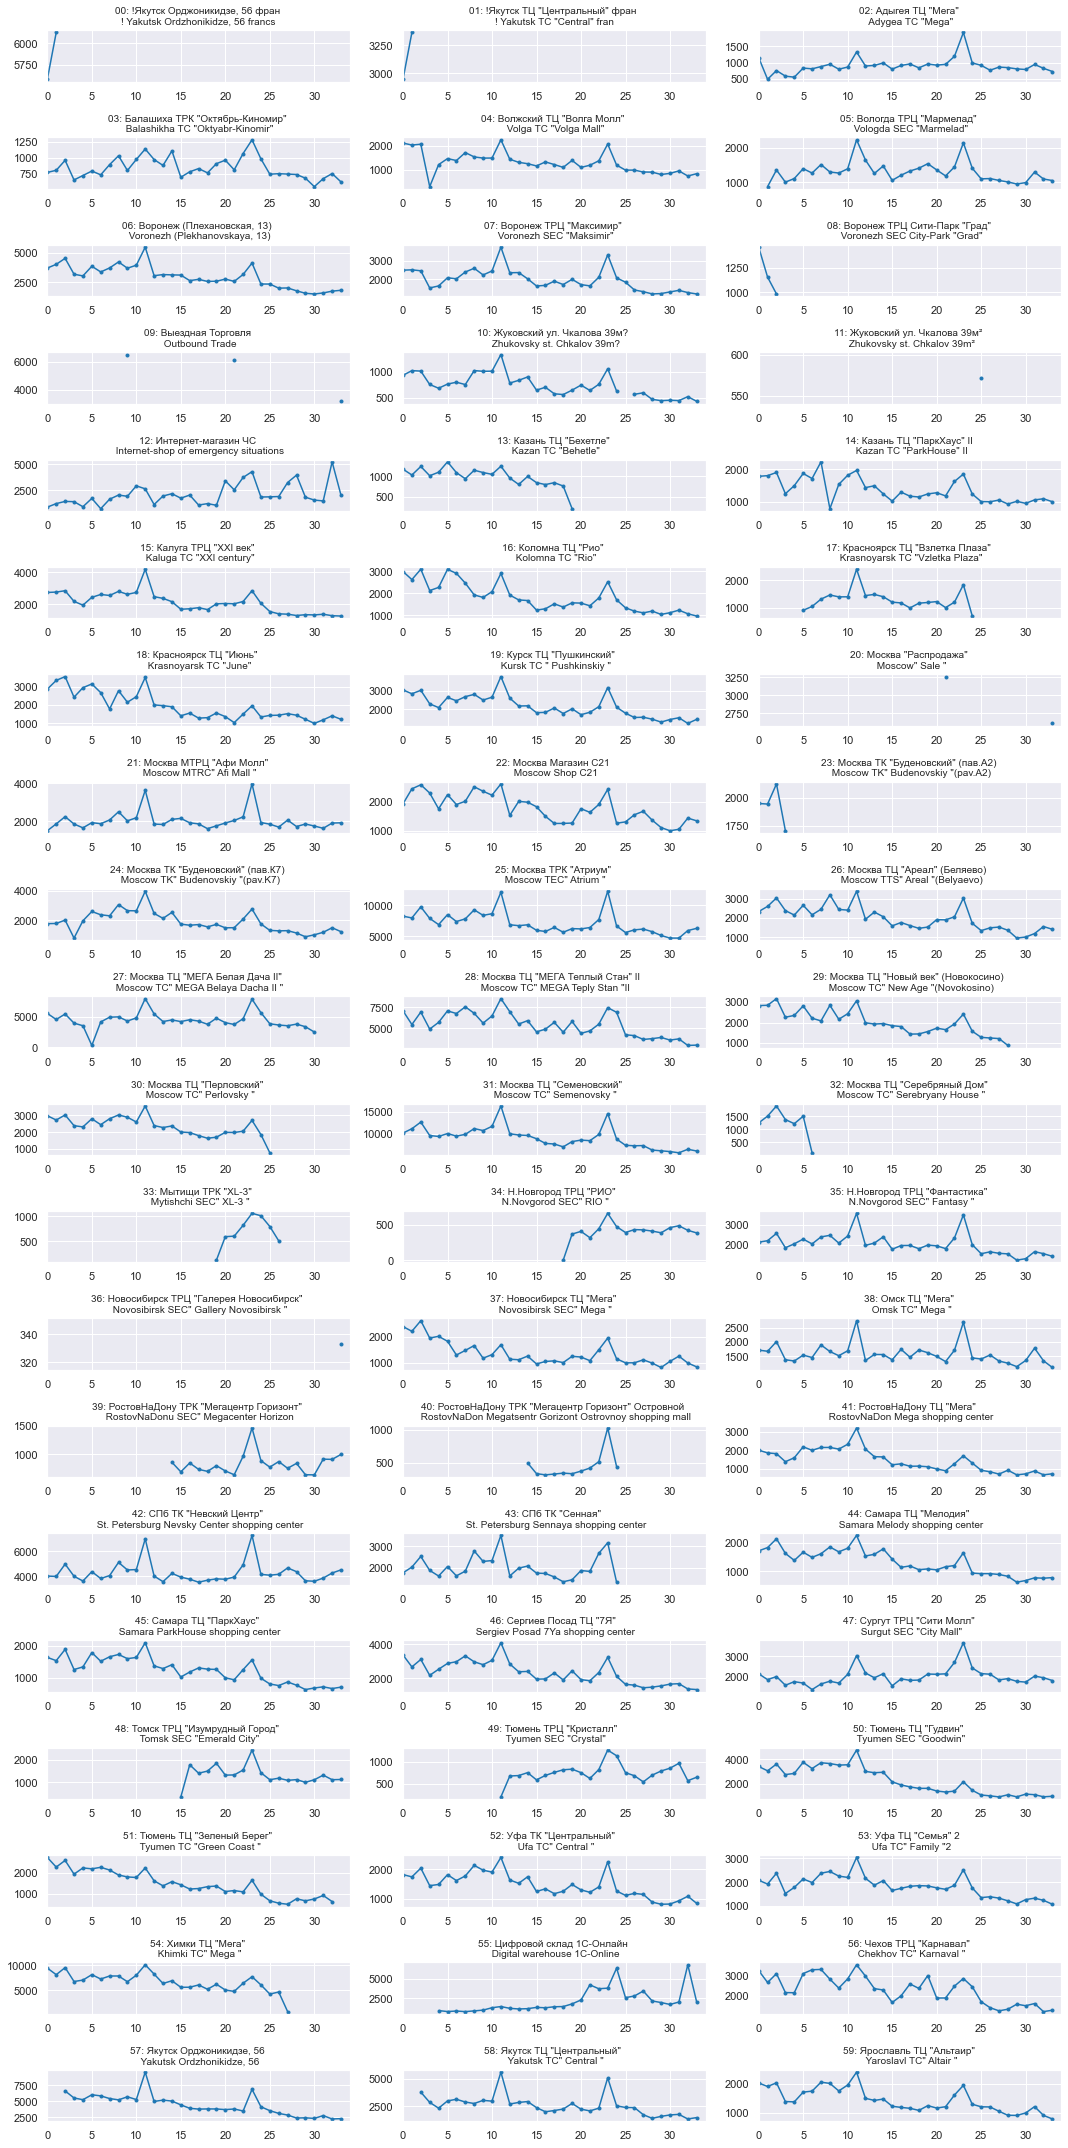

In [15]:
sns.set_context("notebook")
def sales_by_shop():
    shops = pd.read_csv("../input/predict-future-sales-extra/shops_extra.csv")
    shops["shop_name_trans"] = shops["shop_name"] + " \n" + shops["shop_name_en"]
    shopnamedict = {
        id: f"{id:02}: {name}"
        for name, id in zip(list(shops["shop_name_trans"]), list(shops["shop_id"]))
    }

    ts = train.groupby(["date_block_num", "shop_id"])["item_cnt_day"].sum()
    ts = ts.reset_index()
    ts["shop_name_trans"] = ts["shop_id"].map(shopnamedict)
    tsp = ts.pivot(index="date_block_num", columns="shop_name_trans", values="item_cnt_day")
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(20, 3, figsize=(15, 30))
    for i, shop_name in enumerate(tsp.columns):
        idx = divmod(i, axes.shape[1])
        axes[idx[0]][idx[1]].plot(tsp.index, tsp.loc[:, shop_name], marker=".")
        axes[idx[0]][idx[1]].set_xlim(0, 34)
        axes[idx[0]][idx[1]].set_title(shop_name, fontsize=10)
    fig.tight_layout()


sales_by_shop()

### Correct shop labels and remove data from unusual shops
A closer look at these plots finds several data cleaning issues, such as:
* Duplicate shops with minor name differences. Duplicates should be merged.
* Infrequently-used special category shops such as "Outbound Trade". These might distort the model if used during training.
* Some shops cease to exist before the end of the time period covered. These are not essential and removing them may improve performance.  

We will merge the duplicate shops and remove all data from shops not in the test month, for simplicity.  

(A similar check of item categories finds no data quality issues)

In [16]:
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]

### Remove duplicate items

Finally, we'll check for remaining duplicate entries in the training data.

In [17]:
train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,supercategory,platform,digital,supercategory_id,platform_id,shop_name
1435367,2014-02-23,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Games - XBOX 360,Video games,XBOX 360,0,3,6,"Тюмень ТЦ ""Гудвин"""
1496766,2014-03-23,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Games - XBOX 360,Video games,XBOX 360,0,3,6,"Москва МТРЦ ""Афи Молл"""
1671873,2014-05-01,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Games - XBOX 360,Video games,XBOX 360,0,3,6,"Тюмень ТЦ ""Гудвин"""
1866340,2014-07-12,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Games - XBOX 360,Video games,XBOX 360,0,3,6,"Москва ТРК ""Атриум"""
2198566,2014-12-31,23,42,21619,499.0,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37,Cinema - Blu-Ray,Cinema,Blu-Ray,0,4,12,"СПб ТК ""Невский Центр"""


There are only 5 duplicate entries, but the fact that 4 of them are for the same product suggests that they are errors, so we might as well drop them.

In [18]:
train = train.drop_duplicates()
train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,supercategory,platform,digital,supercategory_id,platform_id,shop_name


## Create a model training dataset by reshaping the data
### Aggregate the data by month
The competition challenge was to predict monthly sales totals, so we should create a training set that follows the test format by summing sales for each month.   

The format of the test items is a list of all possible combinations of shops and items for shops and items that recorded at least one sale in the test month, i.e. the Cartesian product of these shops and items. We recreate this by summing the sales for the Cartesian product of active shops and items sold in each month.

In [19]:
def create_testlike_train(sales_train, test=None):
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped,
        how="left",
        on=["date_block_num", "shop_id", "item_id"],
    )

    # Fill emcat_infoy item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

As before, merge the provided items, categories and shops tables.

In [20]:
df = create_testlike_train(train)
df = df.merge(items, on="item_id", how="left")
df = df.merge(item_categories, on="item_category_id", how="left")
df = df.merge(shops, on="shop_id", how="left")

Show the head of the table to check it looks ok.

In [21]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name,item_category_id,item_category_name,supercategory,platform,digital,supercategory_id,platform_id,shop_name
0,0,59,22154,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray,Cinema,Blu-Ray,0,4,12,"Ярославль ТЦ ""Альтаир"""
1,0,59,2552,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,Music - Vinyl,Music,Vinyl,0,6,18,"Ярославль ТЦ ""Альтаир"""
2,0,59,2554,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - Vinyl,Music,Vinyl,0,6,18,"Ярославль ТЦ ""Альтаир"""
3,0,59,2555,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Music - CD of corporate production,Music,CD,0,6,16,"Ярославль ТЦ ""Альтаир"""
4,0,59,2564,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Music - Music video,Music,DVD,0,6,13,"Ярославль ТЦ ""Альтаир"""


## Explore trends and distributions in the data

We can look at the the distributions of target and other features, and look for interesting patterns of relationships between variables.  

The aim of this exploration should be to find patterns in the data that could help predict the target value, and identify the types of prediction model that are appropriate.

### Distribution of the target feature  

We plot an initial histogram of the target item_cnt_month feature, with a smoothed distribution estimate.

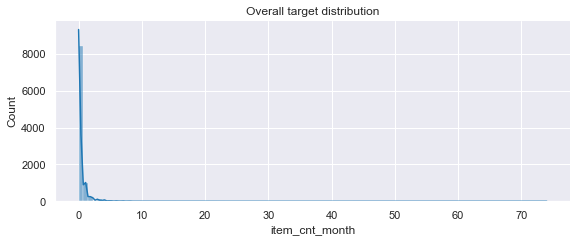

In [22]:
fg = sns.displot(
    df.sample(10000), x="item_cnt_month", bins=100, kde=True
)
_ = fg.fig.set_size_inches(9, 3)
_ = fg.ax.set(title="Overall target distribution")

The distribution clearly has a very large peak close to zero.  Creating sales counts for all items for all shops in each month might lead to lots of entries with zero sales, we should check what proportion of item counts are now zero.

In [23]:
print(f"Proportion of 0-valued targets is {df[df.item_cnt_month==0].shape[0]/df.shape[0]}.")

Proportion of 0-valued targets is 0.8457804166978585.


The distribution of non-zero values would be obscured if all values were plotted together, so we plot the distribution of targets with zero values removed.

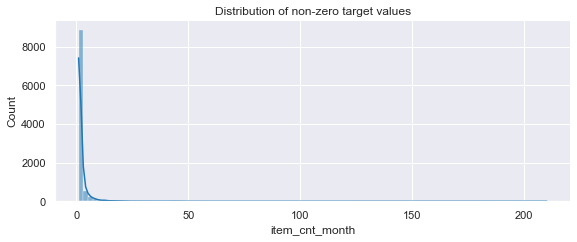

In [24]:
fg = sns.displot(
    df[df.item_cnt_month != 0].sample(10000), x="item_cnt_month", bins=100, kde=True
)
_ = fg.fig.set_size_inches(9, 3)
_ = fg.ax.set(title="Distribution of non-zero target values")

In [25]:
print(f"Proportion of targets greater than 1 is {df[df.item_cnt_month>1].shape[0]/df.shape[0]}.")

Proportion of targets greater than 1 is 0.052576717093067826.


Even with zeros removed, the target is very bottom-heavy, with only around 5% of values above 1, although a small number of items sell much more than this.  

The skewness of the distribution makes linear models unsuitable for predicting future sales of items, as assumptions for linear models will not be met. Instead, non-linear models such as decision trees or k-nearest neighbor models would be more suitable.

### Item price distribution
We can also plot the distribution of items prices. For this, we take the mean price of the item in months in which it was sold. To do with we create a table which summarizes monthly data across all shops.

In [26]:
def all_shops_frame(df):
    items_all_shops = df.groupby(["date_block_num", "item_category_name", "shop_name", "shop_id", "item_id"]).agg(
        {"item_revenue_month": "mean", "item_cnt_month": "sum"}
    )
    items_all_shops = items_all_shops.assign(
        item_price_mean=lambda x: x.item_revenue_month / x.item_cnt_month
    )
    return items_all_shops


df_all = all_shops_frame(df)

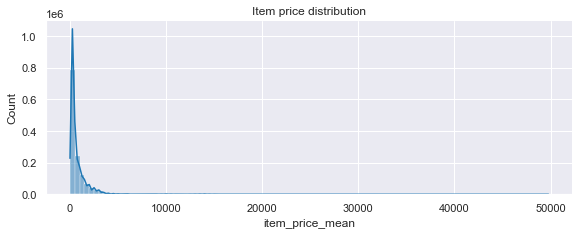

In [27]:
fg = sns.displot(df_all, x="item_price_mean", bins=100, kde=True)
_ = fg.ax.set_title("Item price distribution")
_ = fg.fig.set_size_inches(9,3)

Prices are also highly skewed towards zero. We can display the distribution more clearly by using a log scale.

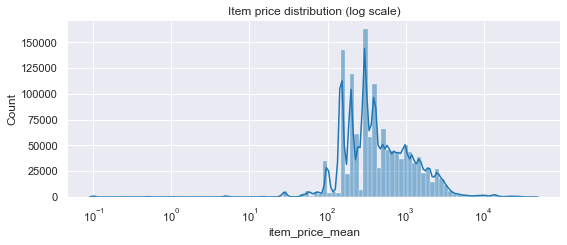

In [28]:
fg = sns.displot(df_all, x="item_price_mean", bins=100, kde=True, log_scale=True)
_ = fg.ax.set_title("Item price distribution (log scale)")
_ = fg.fig.set_size_inches(9,3)

Here we can see that the price distribution is approximately lognormal with a peak slightly below 10.
### Joint distribution of item prices and sales
Finally, we can also plot the joint distribution of monthly items sales and mean prices, again using a log scale for clarity.

C:\Users\grant\anaconda3\envs\eda\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


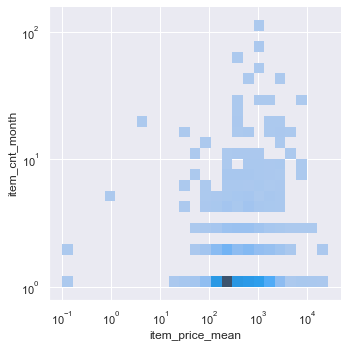

In [29]:
fg = sns.displot(df_all.sample(10000), x="item_price_mean",y="item_cnt_month", bins=25, log_scale=True)

This reveals no strong overall associations between price and sales, although associations may exist in subgroups of the data.  

Outliers are also apparent.

### Overall sales trends over time
Plotting total sales counts per month shows clear downwards and seasonal trends. However the mean number of each item sold per month (which is what is to be predicted) shows a less pronounced downwards trend.


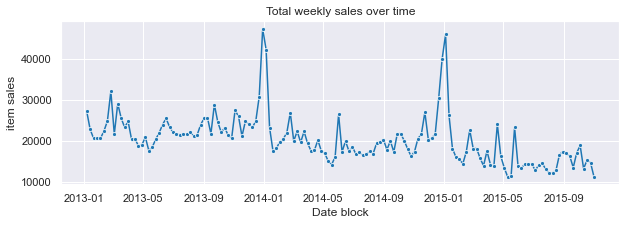

In [30]:
sales_resampled = train.groupby(pd.Grouper(key="date", freq="w")).item_cnt_day.sum()
fig, ax = plt.subplots(figsize=(10, 3))
ax = sns.lineplot(data=sales_resampled, marker=".", markersize=8, ax=ax)
_ = ax.set(xlabel="Date block", ylabel="item sales", title="Total weekly sales over time")

### Seasonally decompose data
Mean sales per item can also be decomposed into seasonal and continuous trends using the _statsmodels_ package. This show a clear yearly seasonal trend (particularly a peak around the winter holidays) and an overall downwards trend that can be assumed to related to the rise of internet and digital-only sales.

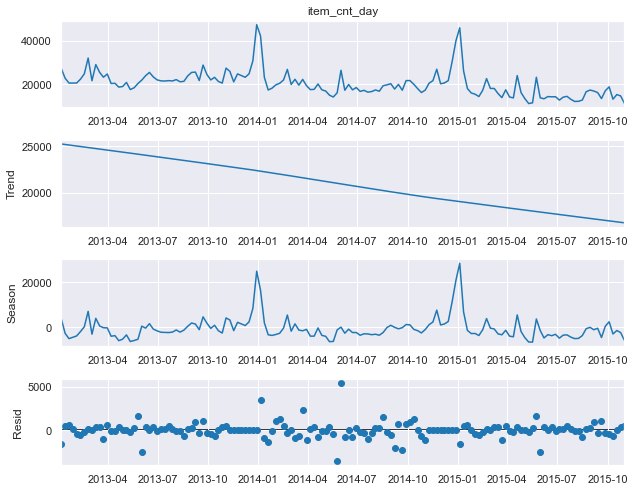

In [31]:
sales_resampled = train.groupby(pd.Grouper(key="date", freq="w")).item_cnt_day.sum()
result = STL(sales_resampled).fit()
fig = result.plot()
fig.set_size_inches((9, 7))
fig.tight_layout()

The overall sales trend is clearly downwards, but there are differences at the item category level. Compare the following trend and seasonal decomposition plots for games for the PS3 and PS4.

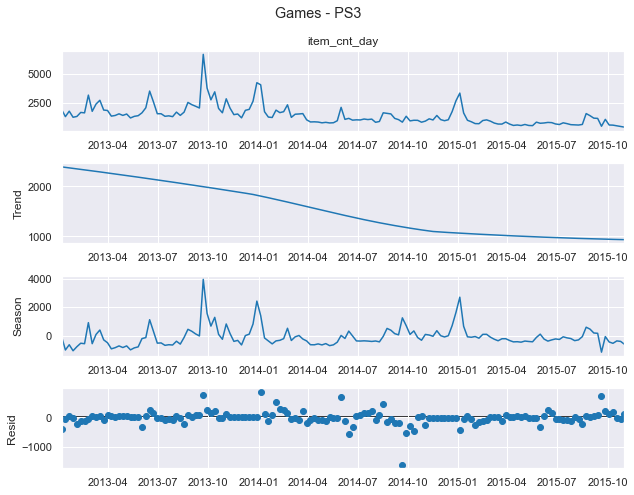

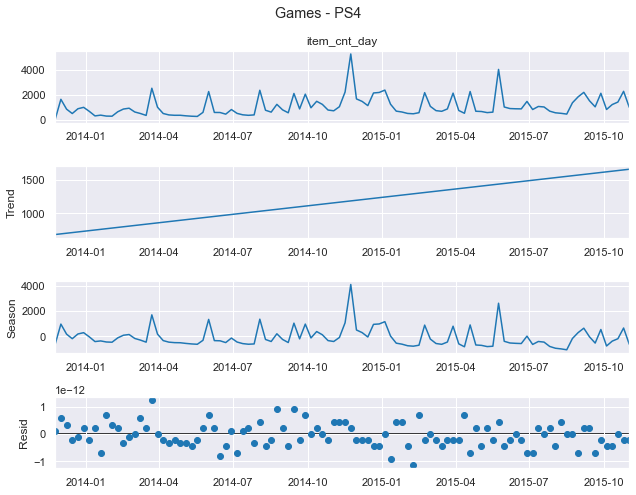

In [32]:
for catname in ["Games - PS3", "Games - PS4"]:
    sales_resampled = (
        train.query(f"item_category_name=='{catname}'")
        .groupby(pd.Grouper(key="date", freq="w"))
        .item_cnt_day.sum()
    )
    result = STL(sales_resampled).fit()
    fig = result.plot()
    fig.set_size_inches((9, 7))
    plt.suptitle(catname)
    fig.tight_layout()
del (sales_resampled, result)

### Sales by item category
Each item is assigned one of 80+ categories which identify what kind of product it is and what format it is for. Information about these categories could be predictive because different types of item are likely to sell in different amounts.

First we plot mean sales and revenue per item in each category across all shops, for the last year of sales data.

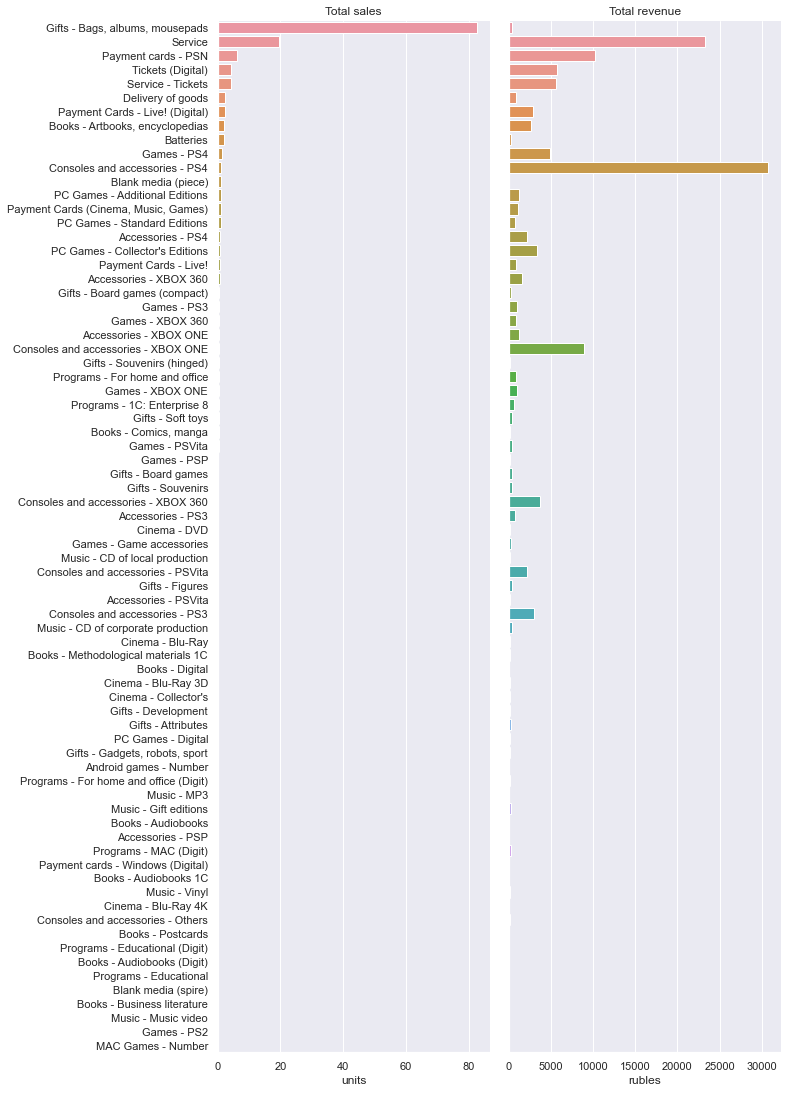

In [33]:
cat_info = (
    df_all.query("date_block_num>21")
    .groupby("item_category_name")
    .agg({"item_cnt_month": "mean", "item_revenue_month": "mean"})
)
cat_info = cat_info.rename(
    columns={
        "item_cnt_month": "Mean sales per item",
        "item_revenue_month": "Mean revenue per item",
    }
)
cat_info = cat_info.reset_index()
cat_info = cat_info.sort_values(by="Mean sales per item", ascending=False)
cat_info = cat_info.melt(id_vars="item_category_name")
fg = sns.catplot(
    data=cat_info, y="item_category_name", x="value", col="variable", kind="bar", sharex=False
)
_ = fg.figure.set_size_inches(12, 18)
_ = fg.axes[0][0].set(title="Total sales", xlabel="units", ylabel=None)
_ = fg.axes[0][1].set(title="Total revenue", xlabel="rubles")

Most obviously this plot shows that items in one particular category - "Gifts - bags, albums, mousepads" - have a much higher sales volume than items in other categories, but comparitively little revenue. This category contains few items and denotes low cost items such as promotional bags and mousemats.  

Economic and predictive importance may be better represented by plotting summed rather than mean values in each category.

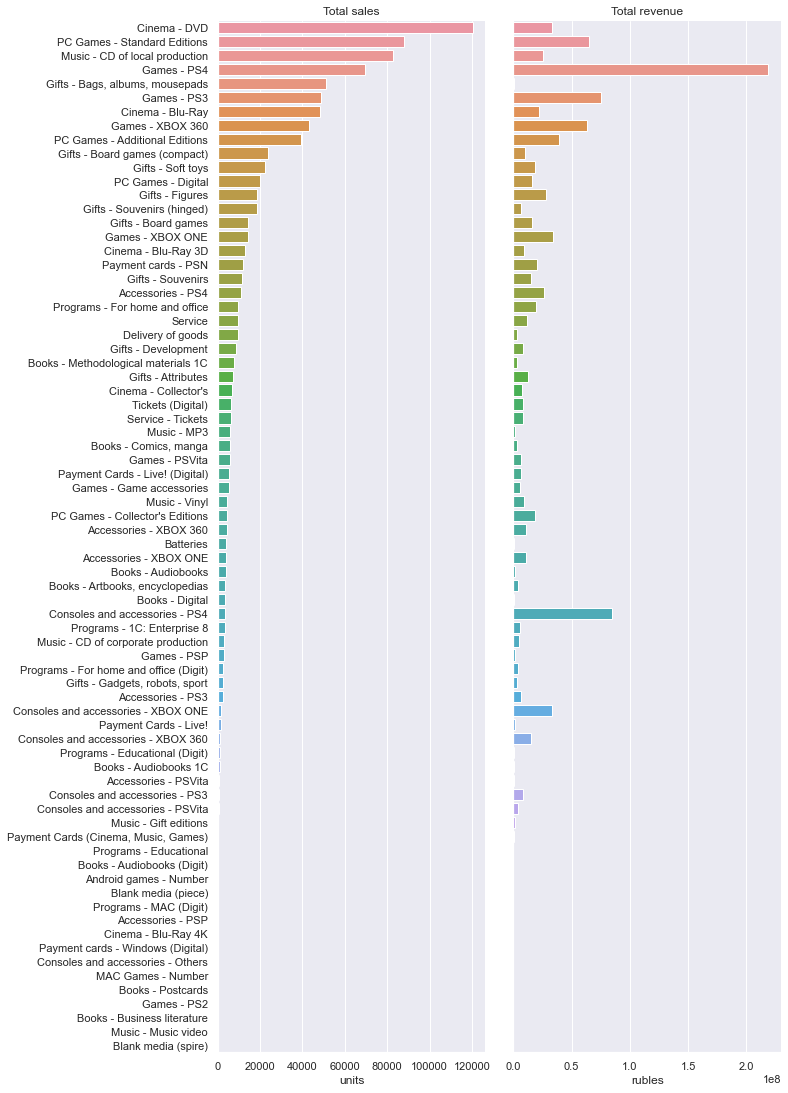

In [34]:
cat_info = df_all.query("date_block_num>21").groupby('item_category_name').agg({"item_cnt_month":"sum", "item_revenue_month":"sum"})
cat_info = cat_info.rename(columns={"item_cnt_month":"Total sales", "item_revenue_month":"Total revenue"})
cat_info = cat_info.reset_index()
cat_info = cat_info.sort_values(by='Total sales', ascending=False)
cat_info = cat_info.melt(id_vars="item_category_name")
fg = sns.catplot(data=cat_info, y = "item_category_name", x="value", col="variable", kind="bar", sharex=False)
_ = fg.figure.set_size_inches(12,18)
_ = fg.axes[0][0].set(title="Total sales", xlabel="units", ylabel=None)
_ = fg.axes[0][1].set(title="Total revenue", xlabel="rubles")

Plotting summed sales shows that movies and games are the highest-selling categories overall, with PS4 games accounting for the most revenue. As well as being predictive in itself, this information could be useful for deciding what categories to prioritize when building predictive models or allocating promotional resources.  

### Sales by shop category
Summed sales can also be plotted when data is grouped according to shop.

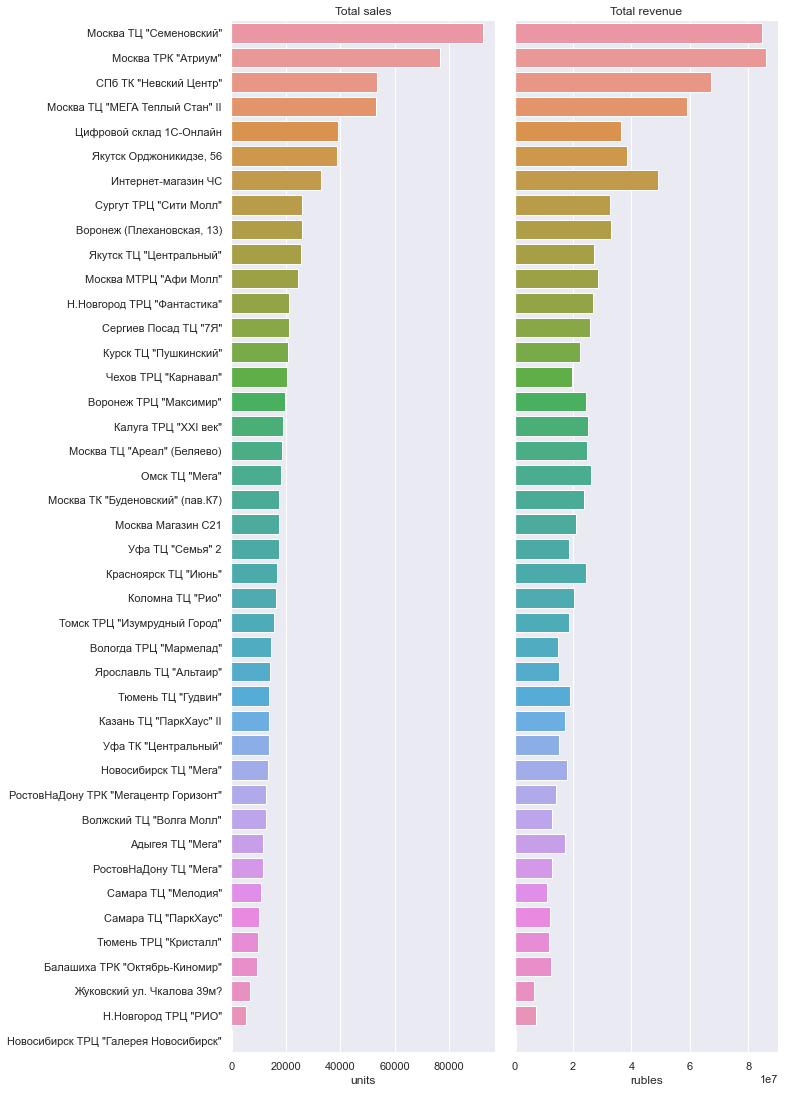

In [35]:
cat_info = df_all.query("date_block_num>21").groupby('shop_name').agg({"item_cnt_month":"sum", "item_revenue_month":"sum"})
cat_info = cat_info.rename(columns={"item_cnt_month":"Total sales", "item_revenue_month":"Total revenue"})
cat_info = cat_info.reset_index()
cat_info = cat_info.sort_values(by='Total sales', ascending=False)
order = cat_info['shop_name']
cat_info = cat_info.melt(id_vars="shop_name")
fg = sns.catplot(data=cat_info, y="shop_name", x="value", col="variable", kind="bar", orient="h", sharex=False, order=order)
_ = fg.figure.set_size_inches(12,18)
_ = fg.axes[0][0].set(title="Total sales", xlabel="units", ylabel=None)
_ = fg.axes[0][1].set(title="Total revenue", xlabel="rubles")

Some shops, paricularly those in Moscow, sell much more items overall than others. All else being equal, an item sold in these shops can be predicted to sell in greater quantities.  

### Shop - category sales profile and decomposition of sales
Some shops sell more than others, but are there differences in the relative quantities of items from each category that shops sell?  

The individual summed sales per category profile of each shop can be created and is plotted here as a heatmap.

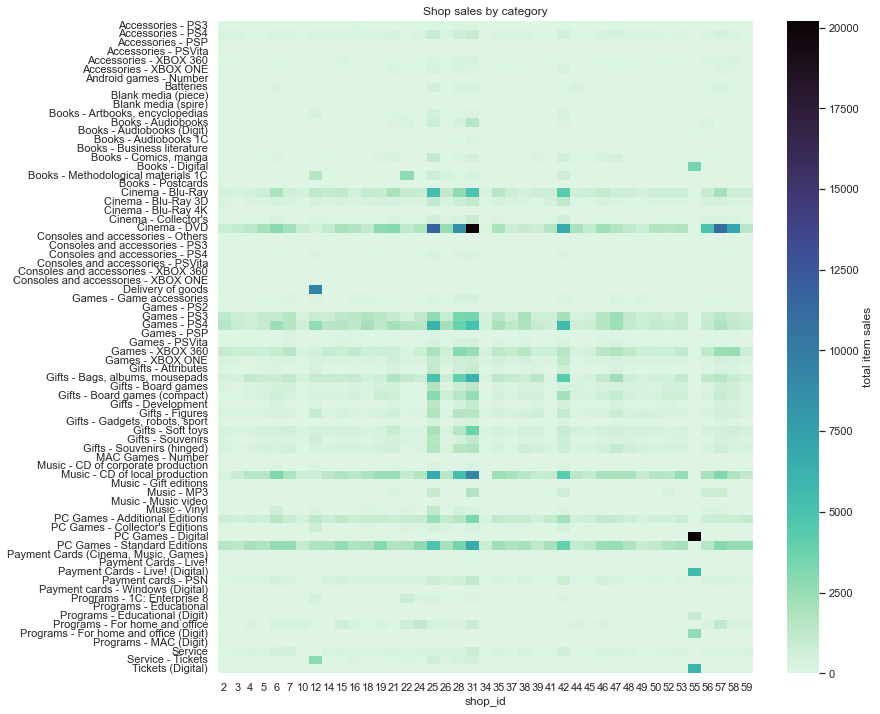

In [36]:
cat_info = train.query("shop_id!=36 & date_block_num>21").pivot_table(values='item_cnt_day', columns='shop_id', index='item_category_name', fill_value=0, aggfunc='sum')
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cat_info, cmap="mako_r", ax=ax, xticklabels=True, yticklabels=True, cbar_kws={"label":"total item sales"})
ax = ax.set(ylabel=None, title="Shop sales by category")

### PCA decomposition and clustering of shops  
The vertical stripes in this heatmap indicate shops that differ from the mean in some way, but high-dimensional data like this can be difficult to understand without some kind of summary.  

Principle component analysis (PCA) lets us decompose high dimensional data into a low dimensional representation that makes it easier to get an overview of patterns in the data. Although the shop-category sales counts do not have the ideal (normal) distribution for use with PCA, we can still do this to try to gain some insight into the similarities and differences between shops.

In [37]:
start_month=21
end_month=33
cat_info = df[df.shop_id.isin(test.shop_id.unique())].query(f"date_block_num>{start_month} & date_block_num<={end_month}")
cat_info = cat_info.pivot_table(values='item_cnt_month', columns='item_category_name', index='shop_id', fill_value=0, aggfunc='sum')

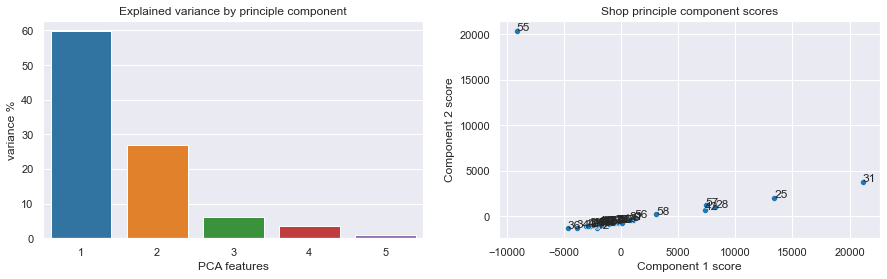

In [38]:
def plot_pca(data, n_components):
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(data)
    transformed = pd.DataFrame(transformed)
    features = list(range(1, pca.n_components_ + 1))
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    _ = sns.barplot(x=features, y=pca.explained_variance_ratio_ * 100, ax=axes[0])
    _ = axes[0].set(
        xlabel="PCA features",
        ylabel="variance %",
        title="Explained variance by principle component",
        xticklabels=features,
    )
    x=transformed[0]
    y=transformed[1]
    _ = sns.scatterplot(x=x, y=y, ax=axes[1])
    _ = axes[1].set(
        xlabel="Component 1 score",
        ylabel="Component 2 score",
        title="Shop principle component scores",
    )
    for i, txt in enumerate(data.index.to_list()):
        axes[1].annotate(str(txt), (x[i], y[i]))
    return pca

pca = plot_pca(cat_info, 5)

The explained variance plot shows that around 85% of the differences between the shops can be explained by two linear components, and that almost all of the shops lie approximately on a straight when plotted on these dimensions.  

Insight into what these components correspond to can be gained by plotting the components that map the component scores to the original data. We do this here for the two components plotted above, and sort the elements of the components by descending magnitude. 

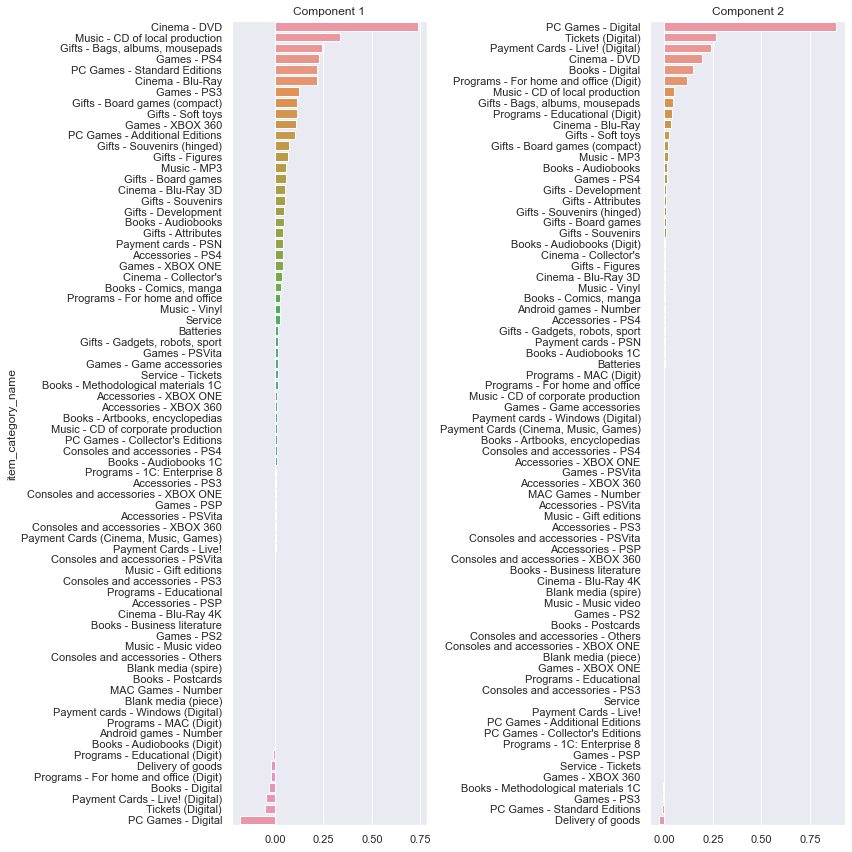

In [39]:
def plot_component(pca, component_num, ax):
    sortidx = np.argsort(pca.components_[component_num])[::-1]
    _ = sns.barplot(
        y=cat_info.columns[sortidx],
        x=pca.components_[component_num][sortidx],
        orient="h",
        ax=ax,
    )
    _ = ax.set(title=f"Component {component_num+1}")

fig, axes = plt.subplots(1, 2, figsize=(12, 12))

plot_component(pca, 0, axes[0])
plot_component(pca, 1, axes[1])

_ = axes[1].set_ylabel(None)
fig.tight_layout()

Looking first at component 2, we see that this is mostly highly weighted on "digital" categories, i.e. non-physical online downloads. The fact that shop 55 is so far from the other shops on this dimension is explained by this being the ID of an online store, and highlights that shop 55 has a very different sales profile to the other shops and that it may help to handle this differently when making predictions.

Th fact that the non-digital shops lie more or less on a straight line in the principle component representation above indicates that the non-digital shops mainly differ in the magnitude of their sales volumes rather than differences in the types of items which they sell.

## Engineered features

### Sales as a function of item age

The age of items when they are sold can be approximately calculated by subtracting from this date the first date or month on which they were sold.  

Total monthly item sales as a function of item age is plotted below for all items, and separately for items in two representative categories.

In [40]:
def item_shop_age_months(matrix):
    matrix["item_age"] = matrix.groupby("item_id")["date_block_num"].transform(
    lambda x: x - x.min()
    )
    matrix["new_item"] = matrix["item_age"] == 0
    matrix["new_item"] = matrix["new_item"].astype("int8")
    matrix["shop_age"] = (
        matrix.groupby("shop_id")["date_block_num"]
        .transform(lambda x: x - x.min())
        .astype("int8")
    )
    matrix["new_shop"] = matrix.shop_age == 0
    matrix["new_shop"] = matrix["new_shop"].astype("int8")
    return matrix

df_all = item_shop_age_months(df_all.reset_index())

Plotting total monthly item sales as a function of their ages that items tend to sell most when they are new and then decline to a plateau about 1 year later. The slightly lower sales in the first compared to the second month is attributable to items not always being available for the whole first month.  

It is also evident that this trend for items to sell most shortly after their release is more evident for some categories, such as movies, compared to others.

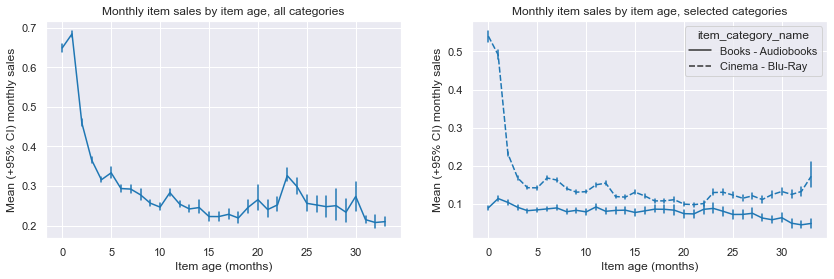

In [41]:
fig, axes = plt.subplots(1,2, figsize = (14,4))
_ = sns.lineplot(data=df_all, x="item_age", y="item_cnt_month", err_style="bars", ci=95, ax=axes[0])
_ = axes[0].set(title = "Monthly item sales by item age, all categories", xlabel="Item age (months)", ylabel="Mean (+95% CI) monthly sales")
_ = sns.lineplot(data=df_all[df_all.item_category_name.isin(("Books - Audiobooks", "Cinema - Blu-Ray"))], x="item_age", y="item_cnt_month",
             style="item_category_name", err_style="bars", ci=95, ax=axes[1])
_ = axes[1].set(title = "Monthly item sales by item age, selected categories", xlabel="Item age (months)", ylabel="Mean (+95% CI) monthly sales")

### Predicting sales from historical sales
Even when taking the decline of sales volume over time into account, it seems likely that items that sell well in one month are likely to also sell well in the following month. A column can be created which contains the sales figures from the previous month for the sale shop-item combination.  

We can create a regression plot of sales counts as a function of previous months sales, for a sample items which are at least a month old. For clarity, we use log scales on the axes and plot the estimate of the central tendency (mean) of item_cnt_month.

In [42]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
        targetseries["date_block_num"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
        )
        matrix.loc[
            (matrix.item_age >= lag) & (matrix.shop_age >= lag) & (matrix[newname].isna()),
            newname,
        ] = 0
    return matrix

In [43]:
df = item_shop_age_months(df)
df = simple_lag_feature(df, 'item_cnt_month', lags=[1])

Adding feature item_cnt_month_lag_1


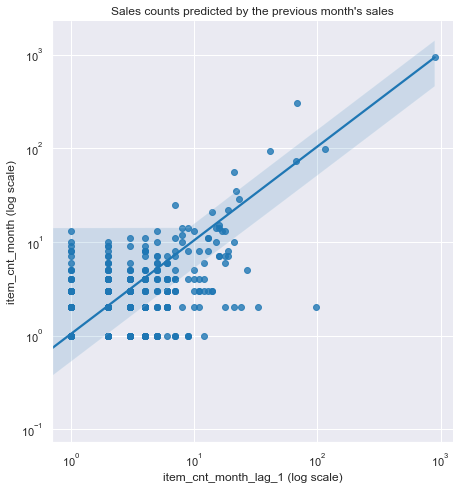

In [44]:
def regplot(x, y, title):
    a = df.query("item_age>0 & shop_age>0").sample(10000)
    fg = sns.lmplot(x=x, y=y, data=a)
    _ = fg.figure.set_size_inches(7, 7)
    _ = fg.ax.set(
        xscale="log",
        yscale="log",
        title=title,
        xlabel=f"{x} (log scale)",
        ylabel=f"{y} (log scale)",
    )


x = "item_cnt_month_lag_1"
y = "item_cnt_month"
title = "Sales counts predicted by the previous month's sales"
regplot(x, y, title)

### Moving average of historical sales.

Sales in individual months are mostly low-valued and tend to be noisy. To reduce this noise, windowing methods can be used to calculate a historical mean as a weighted sum of the sales from multiple previous months. An example showing multiple types of window is shown below.

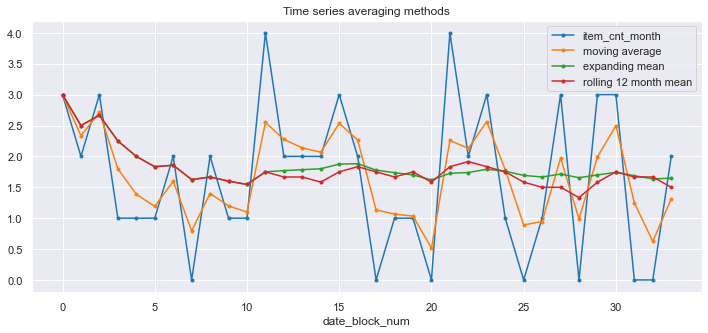

In [45]:
shop_id = 16
item_id = 482
im = df.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

In [46]:
def add_rolling_stats(
    df,
    features,
    window=12,
    kind="rolling",
    argfeat="item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        df,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="item_cnt_month",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # Calculate a statistic on a windowed section of a source table,  grouping on specific features
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        df = df.merge(store, on=feats + ["date_block_num"], how="left")
        return df

    """ An issue when using windowed functions is that missing values from months when items recorded no sales are skipped rather than being correctly
    treated as zeroes. Creating a pivot_table fills in the zeros."""
    if (reshape_source == True) or (kind == "ewm"):
        source = df.pivot_table(
            index=features + ["date_block_num"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = df.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
            source.loc[
                source.index.get_level_values("date_block_num") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = df

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            df,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            df,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = (
            source.groupby(features)[argfeat]
            .ewm(halflife=window, min_periods=1)
            .agg(rolling_aggfunc)
            .to_numpy(dtype=dtype)
        )
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return df.merge(source, on=["date_block_num"] + features, how="left")

In [47]:
df = add_rolling_stats(df, ["shop_id", "item_id"], kind="ewm", window=1)
df = add_rolling_stats(df, ["shop_id", "item_id"], window=12)

Creating feature "shop_id_item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12"


We create windowed 12-month average and exponential moving average (in which recent months are weighed more than less recent months) sales count features and display regression plots below. 

In [48]:
def create_apply_ME(
    matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"
):
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
    return matrix

In [49]:
df = create_apply_ME(df, ["item_id"], target="item_cnt_month")

Adding feature item_id_item_cnt_month_mean_lag_1


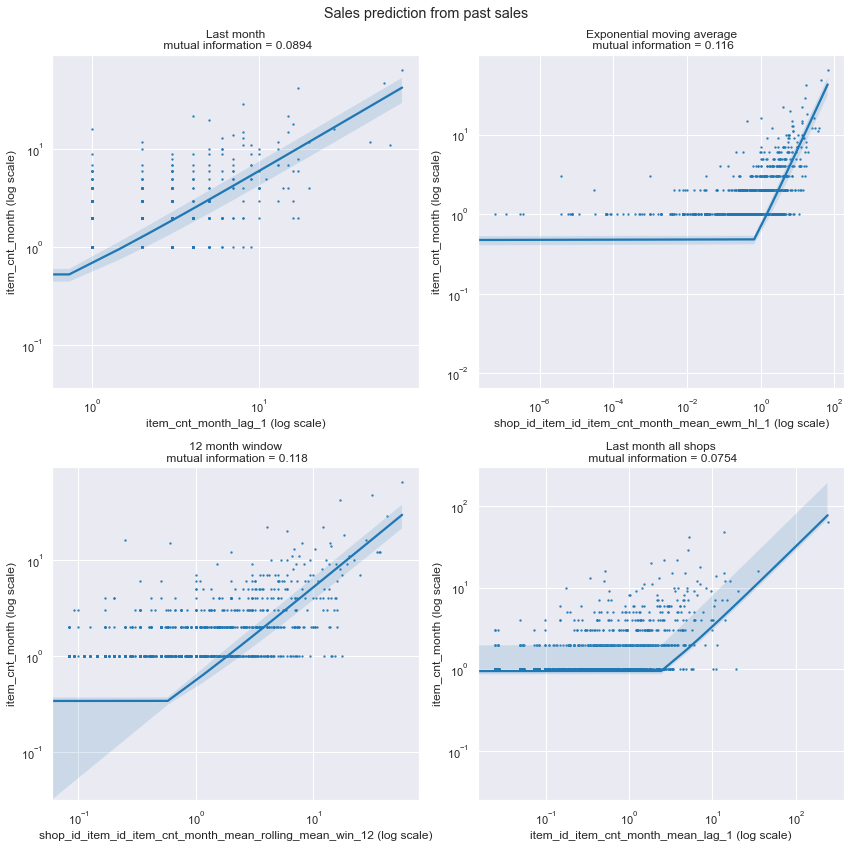

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))


def regplot(data, x, y, title, ax=None):
    score = mutual_info_regression(data[x].to_numpy().reshape(-1, 1), data[y].to_numpy())[0]
    ax = sns.regplot(x=x, y=y, data=data, ax=ax, fit_reg=True, scatter_kws={"s": 2})
    _ = ax.set(
        xscale="log",
        yscale="log",
        title=title + f"\n mutual information = {score:.3}",
        xlabel=f"{x} (log scale)",
        ylabel=f"{y} (log scale)",
    )


x = "item_cnt_month_lag_1"
y = "item_cnt_month"
title = "Last month"
data = df.query("item_age>0 & shop_age>1").sample(10000)
regplot(data, x, y, title, ax=axes[0][0])
title = "Exponential moving average"
regplot(data, "shop_id_item_id_item_cnt_month_mean_ewm_hl_1", y, title, axes[0][1])
title = "12 month window"
regplot(data, "shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12", y, title, axes[1][0])
title = "Last month all shops"
regplot(data, "item_id_item_cnt_month_mean_lag_1", y, title, axes[1][1])
_ = plt.suptitle("Sales prediction from past sales")
_ = plt.tight_layout()

### Predictive information about new items
While previous months sales are useful, for new items this is not available and alternative information must be used to make predictions.

The item category and shop id fields can be used to determine mean item sales counts for items in their first month of sales. This is plotted below for the last year of sales data.

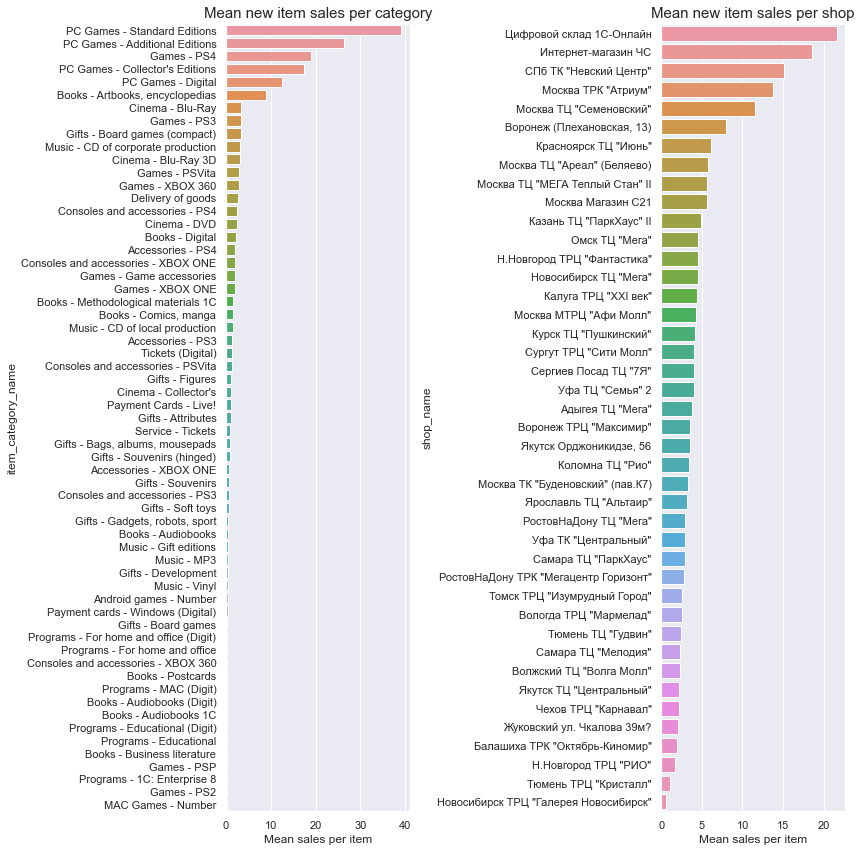

In [51]:
def plot_component(df, group_col, title, ax):
    cat_info = (
        df.query("date_block_num>21 & item_age==0")
        .groupby(group_col)
        .agg({"item_cnt_month": "mean", "item_cnt_month":"std"})
    )
    cat_info = cat_info.reset_index()
    cat_info = cat_info.melt(id_vars=group_col)
    cat_info = cat_info.sort_values(by="value", ascending=False)
    cat_info = cat_info.rename(columns={"value": "Mean sales per item"})
    ax = sns.barplot(data=cat_info, y=group_col, x="Mean sales per item", ax=ax)
    ax = ax.set_title(title, fontsize=15)


fig, axes = plt.subplots(1, 2, figsize=(12, 12))

plot_component(df_all, "item_category_name", "Mean new item sales per category", ax=axes[0])
plot_component(df_all, "shop_name", "Mean new item sales per shop", ax=axes[1])

# _ = axes[1].set_ylabel(None)
fig.tight_layout()

Again, the mean new item sales for item category - shop combinations can also be calculated.

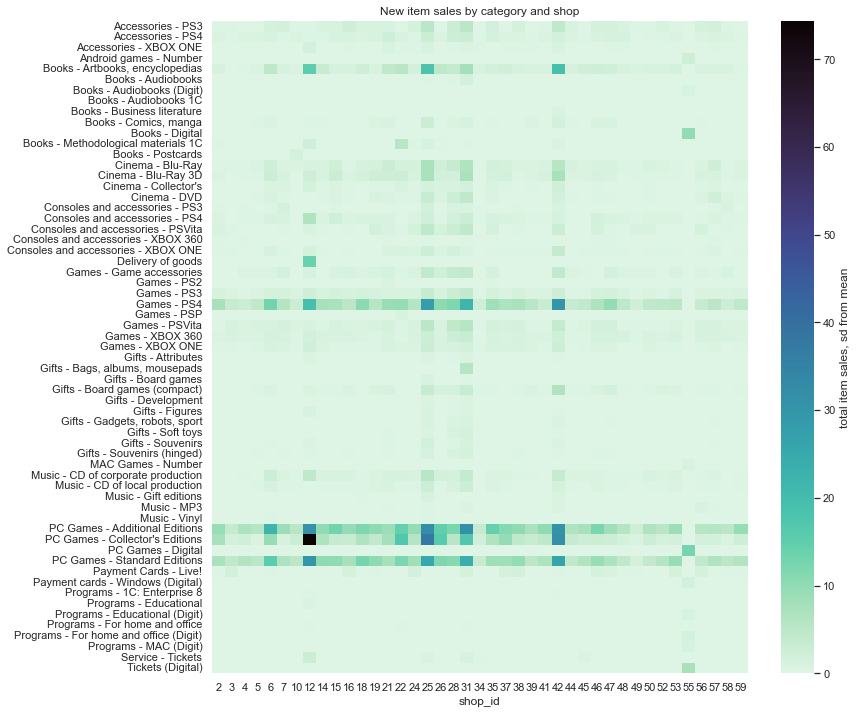

In [52]:
cat_info = df.query("shop_id!=36 & date_block_num>21 & item_age==0").pivot_table(values='item_cnt_month', columns='shop_id', index='item_category_name', fill_value=0, aggfunc='mean')
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cat_info, cmap="mako_r", ax=ax, xticklabels=True, yticklabels=True, cbar_kws={"label":"total item sales, sd from mean"})
ax = ax.set(ylabel=None, title="New item sales by category and shop")

## Shop averages, category averages, shop-category interactions

# Text features

In addition to the information contained in the item categories and shop identities, all items have an associated item_name text feature, which contains a short description of the item that often includes things such as its title, format (e.g. PS4 or PS3) and language.

To aid extraction of information from text it is often useful to clean the text of irrelevant special characters, excess blank spaces, low-information words such as "the", and converting all text to lowercase. If necessary this can be performed by regular expression operations, as demonstrated here:

In [53]:
all_stopwords = stopwords.words("russian") + stopwords.words("english")

def clean_text(string):
    # This cleans the string of special characters, excess spaces and stopwords then extracts the first word
    string = re.sub(r"[^\w\s]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    tokens = string.lower().split()
    tokens = [t for t in tokens if t not in all_stopwords]
    return " ".join(tokens)

items['item_name_clean'] = items['item_name'].apply(clean_text)

items.loc[1000:,["item_name", "item_name_clean"]].head()

,item_name,item_name_clean
1000,"3D Action Puzzle ""Зомби"" Уборщик",3d action puzzle зомби уборщик
1001,"3D Action Puzzle ""Зомби"" Шахтер",3d action puzzle зомби шахтер
1002,"3D Action Puzzle ""Техника"" Бомбардировщик",3d action puzzle техника бомбардировщик
1003,"3D Action Puzzle ""Техника"" Вертолет",3d action puzzle техника вертолет
1004,"3D Action Puzzle ""Техника"" Гоночная машинка",3d action puzzle техника гоночная машинка


One way that the item_name field could be used is by extracting individual words or n-grams (groups of sequential words) and treating them as individual binary categories. Doing this creates a very large number of features so some kind of filtering will likely be necessary, such as specifying minimum numbers of occurences of a word feature. Another feature selection technique is to filter items according to some kind of metric of relevance to the target variable, such as correlation.  

Below is an example of the 1 and 2-ngrams producted from a single item_name text string.

In [54]:
def create_item_id_bow_matrix(items):
    all_stopwords = stopwords.words("russian")
    all_stopwords = all_stopwords + stopwords.words("english")

    vectorizer = CountVectorizer(stop_words=all_stopwords, ngram_range=(1,2))
    X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
    X = pd.DataFrame.sparse.from_spmatrix(X)
    print(f"{len(vectorizer.vocabulary_)} ngrams found in all items")
    featuremap = {
        col: "ng: " + token
        for col, token in zip(
            range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names()
        )
    }
    X = X.rename(columns=featuremap)
    X.index = items.index
    return X

items_short = items.loc[3566:3566,:]
X = create_item_id_bow_matrix(items_short) 
pd.concat((items_short["item_name"], X), axis=1)

9 ngrams found in all items


,item_name,ng: 360,ng: 360 английская,ng: fuse,ng: fuse xbox,ng: xbox,ng: xbox 360,ng: английская,ng: английская версия,ng: версия
3566,"Fuse [Xbox 360, английская версия]",1,1,1,1,1,1,1,1,1


### Grouping similar items with similar names
Items with different item_ids are often related to each other, such as being different versions of the same video game or movie, and so are likely to have related sales figures. This can be taken advantage of by grouping similar items together based on their item_names.  

The Python package TheFuzz implements fuzzy string matching to measure the similarity of sequences of word. The following code uses this with an alphabetical sorting of item names to group related items together. This item name group can be used as other categorical features.  

The example list of items after shows that related items (e.g. the same video game for different consoles) are assigned to the same group.

In [55]:
def partialmatchgroups(items, sim_thresh):
    def strip_brackets(string):
        string = re.sub(r"\(.*?\)", "", string)
        string = re.sub(r"\[.*?\]", "", string)
        return string

    items = items.copy()
    items["nc"] = items.item_name.apply(strip_brackets)
    items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

    def partialcompare(s):
        return fuzz.partial_ratio(s["nc"], s["ncnext"])

    items["partialmatch"] = items.apply(partialcompare, axis=1)
    # Assign groups
    grp = 0
    for i in range(items.shape[0]):
        items.loc[i, "item_name_group"] = grp
        if items.loc[i, "partialmatch"] < sim_thresh:
            grp += 1
    items = items.drop(columns=["nc", "ncnext", "partialmatch"])
    items['item_name_group'] = items['item_name_group'].apply(int)
    return items

items = partialmatchgroups(items, 65)

items.query("item_id>3564")[["item_name", "item_name_group"]].head(5)

,item_name,item_name_group
3565,"Fuse [PS3, английская версия]",1362
3566,"Fuse [Xbox 360, английская версия]",1362
3567,G Data Internet Security 2013 (1ПК / 1 год) (G...,1363
3568,G Data Internet Security 2013 (3ПК / 1 год) (G...,1363
3569,GABIN The Best Of Gabin 2CD,1364


### Mean encoding and none-stationarity of category sales  
Categorical features such as name groups and shop ids have useful predictive information, but the relationship between category values and the target variable is not consistent over the training data, as items, item categories and shops increase or (more often) decline in popularity over time.

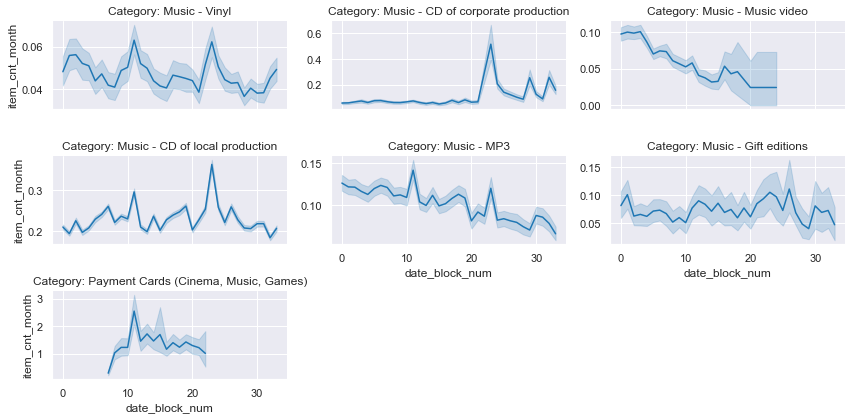

In [56]:
fg = sns.relplot(
    data=df[df["item_category_name"].apply(lambda x: "music" in x.lower())],
    x="date_block_num",
    y="item_cnt_month",
    kind="line",
    col="item_category_name",
    col_wrap=3,
    height=2,
    aspect=2,
    facet_kws={"sharey":False},
)
fg = fg.set_titles("Category: {col_name}")

Theoretically, a model could learn the interactions between individual category values and time periods, but for categorical features with high numbers of values, such as item identities and name groups, this could require very complex models and cause problems with overfitting.  

To save the predictive model having to learn the individual relationships between individual category values and specific time periods, a useful solution is to turn categorical variables into numerical variables by reencoding each value of the category as the mean of the target variable with items with this value, for some time window before the time of the current item. As with individual items, different time windows can be used.  

Here are show example windowed mean encodings for 3 values of the item category name feature using 3 different temporal windows.

In [57]:
df = add_rolling_stats(df, ["item_category_name"], kind="ewm", window=1)
df = add_rolling_stats(df, ["item_category_name"], window=12)
df = add_rolling_stats(df, ["item_category_name"], window=1)

Creating feature "item_category_name_item_cnt_month_mean_ewm_hl_1"
Creating feature "item_category_name_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "item_category_name_item_cnt_month_mean_rolling_mean_win_1"


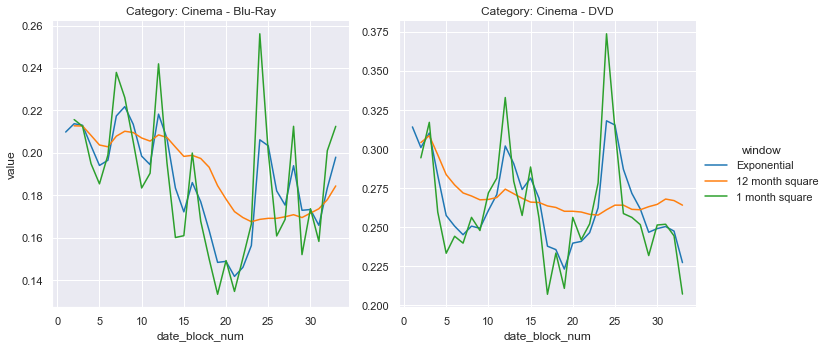

In [59]:
features = [
    "item_category_name_item_cnt_month_mean_ewm_hl_1",
    "item_category_name_item_cnt_month_mean_rolling_mean_win_12",
    "item_category_name_item_cnt_month_mean_rolling_mean_win_1",
]
data = df.groupby(["date_block_num", "item_category_name"])[features].mean()
newnames = ["Exponential", "12 month square", "1 month square"]
data = data.rename(columns={old:new for old, new in zip(features, newnames)})

data = data.reset_index().melt(id_vars=["date_block_num", "item_category_name"], value_vars=newnames, var_name="window")

querycats = ["Cinema - DVD", "Cinema - Blu-Ray"]

fg = sns.relplot(
    data=data.loc[data.item_category_name.isin(querycats), :],
    x="date_block_num",
    y="value",
    hue="window",
    kind="line",
    col="item_category_name",
    col_wrap=2,
    facet_kws={"sharey":False},
#     title="Windowed mean encodings"
)
fg = fg.set_titles("Category: {col_name}")